In [17]:
#импортируем все необходимые библиотеки
import pandas as pd
import pandahouse  as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

Подключаемся к Clickhouse при помощи библиотеки pandahouse

In [45]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'project_variant_2',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [46]:
connection_test = dict(database='test',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student-rw',
                  password='656e2b0c9c')

Выгружаем из базы данных таблицу с группировкой по типу жилья, средними ценами и рейтингом

In [47]:
q = '''
    SELECT
        avg(toFloat64OrNull(replaceRegexpAll(price, '[$,]', ''))) as price,
        room_type,
        avg(toFloat32OrNull(review_scores_rating)) as review_scores_rating
    FROM default.ldn_listings
    GROUP BY room_type
'''

In [48]:
#считываем данные
df = ph.read_clickhouse(query=q, connection=connection_default)
df

,price,room_type,review_scores_rating
0,357.625984,Hotel room,85.786458
1,63.332954,Private room,93.156013
2,125.076809,Shared room,87.198847
3,174.837720,Entire home/apt,92.301768


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


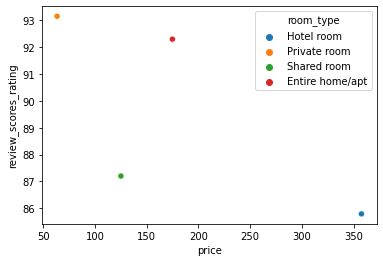

In [9]:
#смотрим на график соотношения цены и рейтинга для разных типов жилья
sns.scatterplot(df['price'], df['review_scores_rating'], hue=df['room_type'])

Исследуем различные способы верификации хозяев, предлагающий различные Впечатления

In [11]:
#пишем новый запрос, чтоб получить таблицу с id хозяев и способами верификации, которые они использовали
query = '''
    SELECT
        DISTINCT host_id,
        host_verifications
    FROM ldn_listings
    WHERE
        experiences_offered != 'none'
    '''

In [13]:
#считываем данные
exp_host = ph.read_clickhouse(query=query, connection=connection_default)
exp_host.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [14]:
#приводим значения в колонке host_verification к списку (вместо строки)
exp_host.host_verifications = exp_host.host_verifications.apply(lambda row: ast.literal_eval(row))

In [15]:
#считаем, сколько раз встречается каждый из способов верификации
exp_host.explode('host_verifications').host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

Как мы видим, в первую очередь хосты используют верификацию по номеру телефона и e-mail.

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 

In [23]:
#пишем новый запрос на получение таблицы, которая содержить название района, тип впечатления и количество 
#объявлений с данными впечатлениями (к тому же исходная база данных была отсортирована по количеству объявлений
#и взято только 100 из них)
q = '''
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(DISTINCT host_id) as experiences_count
FROM ldn_listings
WHERE
    experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100
'''

In [27]:
#считываем данные
neigbourhood = ph.read_clickhouse(query=q, connection=connection_default)
neigbourhood.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,59
1,Hackney,social,47
2,Westminster,business,45
3,Tower Hamlets,business,44
4,Islington,family,43


In [28]:
#преобразуем исходную таблицу в более удобный вид (видно, какой район какое впечатление больше всего вызывает)
neigbourhood = neigbourhood.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
neigbourhood

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Brent,8.0,19.0,5.0,5.0
Bromley,3.0,2.0,NaN,4.0
Camden,32.0,28.0,19.0,23.0
City of London,6.0,NaN,NaN,NaN
Croydon,2.0,3.0,NaN,3.0
Ealing,6.0,12.0,1.0,5.0
Enfield,3.0,NaN,NaN,NaN


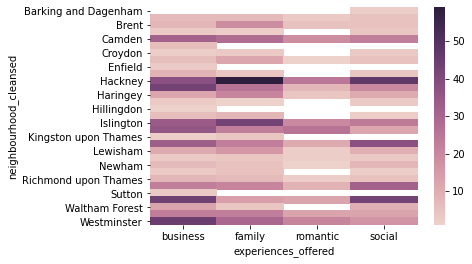

In [29]:
#визуализируем данные
sns.heatmap(neigbourhood, cmap=sns.cubehelix_palette(as_cmap=True))

Исходя из графика мы видим, что наиболее "семейный" район это Hackney, "бизнес" это Sutton и Westminster

Теперь исследуем данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 

In [31]:
q2 = '''
    SELECT 
        room_type,
        toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM {db}.ldn_listings
    WHERE 
        experiences_offered != 'none'
'''

In [32]:
#считываем данные
type_price = ph.read_clickhouse(query=q2, connection=connection_default)
type_price.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


Теперь визуализируем данные, а также посмотрим на график прологорифмированных данных

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


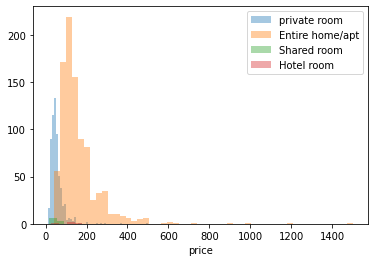

In [34]:
sns.distplot(type_price.query("room_type == 'Private room'").price, kde=False, label='private room')
sns.distplot(type_price.query("room_type == 'Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(type_price.query("room_type == 'Shared room'").price, kde=False, label='Shared room')
sns.distplot(type_price.query("room_type == 'Hotel room'").price, kde=False, label='Hotel room')
plt.legend()
plt.show()

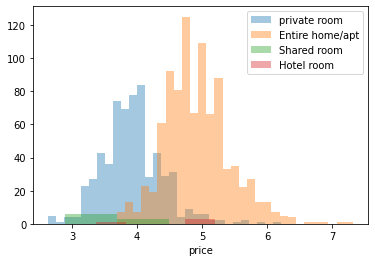

In [35]:
sns.distplot(np.log(type_price.query("room_type == 'Private room'").price), kde=False, label='private room')
sns.distplot(np.log(type_price.query("room_type == 'Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(type_price.query("room_type == 'Shared room'").price), kde=False, label='Shared room')
sns.distplot(np.log(type_price.query("room_type == 'Hotel room'").price), kde=False, label='Hotel room')
plt.legend()
plt.show()

Как мы видим, нагляднее оказался график с прологарифмированными значениями. Самый дорогой тип жилья - Entire home/apt. Самые дешевые - shared room и hotel room.

Теперь выгрузим данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года.

In [36]:
q3 = '''
    SELECT 
        room_type,
        toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
        first_review
    FROM {db}.ldn_listings
    WHERE 
        first_review > '2010-01-01'
    LIMIT 1000

'''

In [37]:
#считываем данные
reviews = ph.read_clickhouse(query=q3, connection=connection_default)
reviews.head()

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [42]:
#оставляем от даты только год
reviews.first_review = reviews.first_review.apply(lambda row: row[0:4])

In [43]:
#сортируем по дате первого отзыва от старого к новому
reviews = reviews.sort_values('first_review')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


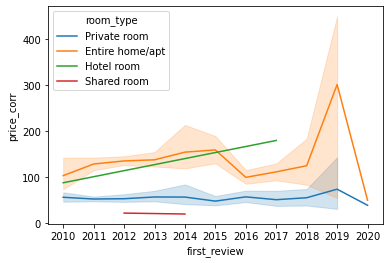

In [44]:
#визуализируем данные
sns.lineplot(reviews['first_review'], reviews['price_corr'], hue = reviews['room_type'])